In [ ]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_book(title_path):
    with open(title_path, "r", encoding ="utf8") as current_file:
        text = current_file.read()
        text = text.replace("\n", "").replace("\r", "")
    return text

In [ ]:
book1 = read_book('drive/MyDrive/Harry_potter_ell881/Book1.txt')
book2 = read_book('drive/MyDrive/Harry_potter_ell881/Book2.txt')
book3 = read_book('drive/MyDrive/Harry_potter_ell881/Book3.txt')
book4 = read_book('drive/MyDrive/Harry_potter_ell881/Book4.txt')
book5 = read_book('drive/MyDrive/Harry_potter_ell881/Book5.txt')
book6 = read_book('drive/MyDrive/Harry_potter_ell881/Book6.txt')
char_list = pd.read_csv('drive/MyDrive/Harry_potter_ell881/characters_list.csv')


train_set = book1 + book2 + book3 + book4 + book5 + book6

In [ ]:
# Convert to lower case
train_set = train_set.lower()
train_set[:100]

'/ the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they '

In [ ]:
# Remove '\n' from the corpus
import re
train_set_clean = re.sub('\n','',train_set)
# train_set_clean[:100]

'/ the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they '

In [ ]:
import string

for p in string.punctuation:
    if p not in ['.',',']: 
        train_set_clean = train_set_clean.replace(p,'')
# train_set_clean[:100]

' the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they w'

In [ ]:
train_set_clean = re.sub("page[a-z0-9\s]*j.k. rowling",'', train_set_clean)

In [ ]:
# train_set_clean.count('page')

In [ ]:
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
hp_sentence_token = sent_tokenize(train_set_clean)
# print(hp_sentence_token[:5])

In [ ]:
# len(hp_sentence_token)

46394

In [ ]:
# puncta =  ['.',',','“','’','”','—','...']
# # remove more punctuations
# def rem_punc(text):
#   text = ' '.join([word for word in text.split() if word not in puncta])
#   return text

In [ ]:
# for s in hp_token:
#   s = rem_punc(s)

In [ ]:
# corpus = ' '.join(hp_token)

In [ ]:
# v = word_tokenize(train_set_clean)
# v = set(v)
# vocab_size = len(v)
# vocab_size

22330

In [ ]:
from itertools import islice
import functools
import operator
import random, collections
import math
import numpy as np
import heapq
import pprint
import time

def window(seq, ngram):
	it = iter(seq)
	result = tuple(islice(it, ngram))
	if len(result) == ngram:
		yield result
	for elem in it:
		result = result[1:] + (elem,)
		yield result

def flatten(container):
	for i in container:
		if isinstance(i, (list,tuple)):
			for j in flatten(i):
				yield j
		else:
			yield i



class LanguageModel:
	def __init__(self, n, backoff_alpha = 0.4, smoothing_k = 0.01):
		self.ngram = n
		self.vocabulary = set()
		self.count = {}
		self.backoff_count = [{} for _ in range(n+1)]
		self.smoothing_k = smoothing_k
		self.backoff_alpha = backoff_alpha
		self.backoff_feedback = 0.0

	def train(self, token_sequences):
		self.vocabulary = set(flatten(token_sequences))
		self.vocabulary.add(None)
		for item in token_sequences:
			for subitem in self.get_ngrams(item, self.ngram):
				if subitem[:self.ngram-1] not in self.count:
					self.count[subitem[:self.ngram-1]] = {subitem[self.ngram-1:][0]: 1}
				else:
					if subitem[self.ngram-1:][0] in self.count[subitem[:self.ngram-1]]:
						self.count[subitem[:self.ngram-1]][subitem[self.ngram-1:][0]] += 1
					else:
						self.count[subitem[:self.ngram-1]][subitem[self.ngram-1:][0]] = 1

	def backoff_context(self, token_sequences):
		n = self.ngram
		self.vocabulary = set(flatten(token_sequences))
		self.vocabulary.add(None)
		for item in token_sequences:
			for i in range(1,n+1):
				for subitem in self.get_ngrams(item, i):
					if subitem[:i-1] not in self.backoff_count[i]:
						self.backoff_count[i][subitem[:i-1]] = {subitem[i-1:][0]: 1}
					else:
						if subitem[i-1:][0] in self.backoff_count[i][subitem[:i-1]]:
							self.backoff_count[i][subitem[:i-1]][subitem[i-1:][0]] += 1
						else:
							self.backoff_count[i][subitem[:i-1]][subitem[i-1:][0]] = 1
	

	def smoothing_good_turing(self):
		numb_token = {}
		for item in self.count:
			for key, value in self.count[item].items():
				if value in numb_token:
					numb_token[value] += 1
				else:
					numb_token[value] = 1
		
		for item in self.count:
			for k,v in self.count[item].items():
				if v+1 in numb_token:
					self.count[item][k] = (v+1)*numb_token[v+1] / numb_token[v]
				else:
					self.count[item][k] = 0
	
	def normalize(self, word_counts):
		prob_dict = {}
		total = sum(word_counts.values())
		for key, value in word_counts.items():
			prob_dict[key] = value/total
		
		return prob_dict

	def normalize_add_k(self, word_counts):
		prob_dict = {}
		total = sum(word_counts.values())
		for key, value in word_counts.items():
			prob_dict[key] = (value + self.smoothing_k) / (total + self.vocabulary*self.smoothing_k)

	def p_next(self, tokens):
		tokens = tokens[-(self.ngram-1):]
		if self.ngram != 1:
			return self.normalize_add_k(self.count[tuple(tokens)])
		else:
			total = sum(list(self.count[()].values()))
			rand_pair = random.choice( list(self.count[()].items()))
			rand_prob = rand_pair[1] / total #len(self.vocabulary)
			return {rand_pair[0]:rand_prob}

	def generate(self, length = 33):
		tokens = [None]* (self.ngram-1)
		for _ in range(length):
			temp_dict = self.p_next(tokens)
			if self.ngram == 1:
				total = sum(list(temp_dict.values()))
				for key, value in temp_dict.items():
					temp_dict[key] /= total
			tokens.append(self.sample(temp_dict)[0])
		return tokens	

	def sample(self, distribution):
		k = np.random.choice(list(distribution.keys()), 1, p = list(distribution.values()))[0]
		v = distribution[k]
		return (k, v)
			
	def perplexity(self, data):
		n = self.ngram
		perplexity = 0
		num = 0
		for item in data:
			for subitem in self.get_ngrams(item, n):
				num += 1
				temp = self.ngram_probability_kn(subitem[:self.ngram-1], subitem[self.ngram-1:][0])
				if temp != 0:
					perplexity += math.log(temp, 2)
		# print(perplexity)
		perplexity = math.pow(2, -1*(perplexity/num))
		return perplexity, num

	def ngram_probability(self, ngram, word):
		if ngram in self.count:
			if word in self.count[ngram] and self.count[ngram][word] > 0:
				count = self.count[ngram][word]
				total = sum(list(self.count[ngram].values()))
			else:
				count = 1
				total = sum(list(self.count[ngram].values()))+1
			if total == 0:
				print(self.count[ngram])
				print(self.count[ngram].values())
			prob = count/ total
		else:
			prob = random.random() / len(self.vocabulary)
		return prob

	def ngram_probability_backoff(self, ngram, word):
		i = self.ngram
		while ngram not in self.backoff_count[i]:
			i -= 1
			ngram = ngram[1:]
		if i > 0:
			if word in self.backoff_count[i][ngram]:
				count = self.backoff_count[i][ngram][word]
				total = sum(self.backoff_count[i][ngram].values())
			else:
				count = 1
				total = sum(self.backoff_count[i][ngram].values()) + 1
			prob = count / total
		else:
			prob = random.random() / len(self.vocabulary)
		if i != self.ngram:
				self.backoff_feedback += 1 / self.backoff_alpha
				# print('feed: ',self.backoff_feedback)
				prob *= self.backoff_alpha
		return prob
		
	def ngram_probability_interpolation(self, ngram, word):
		n = self.ngram
		prob = 0.0
		for i in range(n,0,-1):
			# if(i == 1):
			# 	print(ngram)
			if ngram in self.backoff_count[i]:
				if word in self.backoff_count[i][ngram]:
					count = self.backoff_count[i][ngram][word]
					# if(i == 1):
					# 	print('count ', count)
					total = sum(self.backoff_count[i][ngram].values())
					# if(i == 1):
					# 	print('total ', total)
				else:
					count = 1
					total = sum(self.backoff_count[i][ngram].values()) + 1
				prob += (1/n) * (count / total)
			else:
				prob += (1/n) * (random.random() / len(self.vocabulary))
			ngram = ngram[1:]
		return prob

	def ngram_probability_kn(self, ngram, word):
		d = 0.75
		word_appear = 0
		total_contexts = 0
		for item in self.count.items():
			for key,value in item[1].items():
				total_contexts += 1
				if key == word:
					word_appear += 1

		if ngram in self.count:
			if word in self.count[ngram]:
				count = self.count[ngram][word]
				total = sum(list(self.count[ngram].values()))
				aux = max(count - d, 0)/ total + ((d *len(list(self.count[ngram].values()))) / total) * (word_appear/total_contexts)
			else:
				total = sum(list(self.count[ngram].values()))
				aux = ((d *len(list(self.count[ngram].values()))) / total) * (word_appear/total_contexts)
			# if total == 0:
				# print(self.count[ngram])
				# print(self.count[ngram].values())
			prob = aux
		else:
			prob = random.random() / len(self.vocabulary)
		return prob

	def get_ngrams(self, token, n):
		sequence = []
		if not token:
			return sequence
		if n!=1:
			token = [None]*(n-1) + token + [None]*(n-1)
		else:
			token = token + [None]
		result = window(token, n)
		for r in result:
			sequence.append(r)
		return sequence

Generation of Sentences

In [ ]:
model = LanguageModel(6)
nested_train_list = []
for s in hp_sentence_token:
  words = word_tokenize(s)
  puncta = ['.',',','“','’','”','—','...']
  words = [w for w in words if w not in puncta]
  # if(words.count('explode.') != 0):
  #   print(words)
  nested_train_list.append(words)
model.train(nested_train_list)
# print(model.count.items())
k = model.generate()
result = ''
for x in k:
  if x != None:
    result += x + ' '
print(result)

Testing

In [ ]:
test_set = read_book('drive/MyDrive/Harry_potter_ell881/Book7.txt')
test_set = test_set.lower()
test_set_clean = re.sub('\n','',test_set)

# For loop to replace each punctuation mark with None in the corpus
for p in string.punctuation:
    # not removed in the corpus, as it is used to differentiate the sentences
    if p not in ['.',',']: 
        test_set_clean = test_set_clean.replace(p,'')

test_set_clean = re.sub("page[a-z0-9\s]*j.k. rowling",'', test_set_clean)

test_token = sent_tokenize(test_set_clean)

nested_test_list = []
for s in test_token:
  words = word_tokenize(s)
  puncta = ['.',',','“','’','”','—','...']
  words = [w for w in words if w not in puncta]
  nested_test_list.append(words)

In [ ]:
nested_train_list = []
for s in hp_sentence_token:
  words = word_tokenize(s)
  puncta = ['.',',','“','’','”','—','...']
  words = [w for w in words if w not in puncta]
  nested_train_list.append(words)

In [ ]:
ng = [1,2,3,4,5]
ppl_scores = []
for i in range(1,6):
  model = LanguageModel(i)
  model.train(nested_train_list)
  avg_perplexity_score = 0.0
  avg_perplexity_score, ngram_count = model.perplexity(nested_test_list)
  ppl_scores.append(avg_perplexity_score)

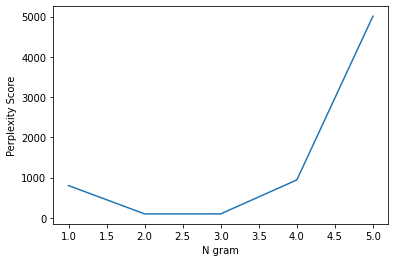

In [ ]:
plt.plot(ng, ppl_scores)
plt.xlabel("N gram")
plt.ylabel("Perplexity Score")
plt.show()

Training started...
1
22324
Training started...
Training 2000 tokens
Training 5000 tokens
Training 6000 tokens
Training 6000 tokens
Training 7000 tokens
Training 7000 tokens
Training 9000 tokens
Training 9000 tokens
Training 9000 tokens
Training 9000 tokens
Training 9000 tokens
Training 9000 tokens
Training 9000 tokens
Training 10000 tokens
Training 10000 tokens
Training 11000 tokens
Training 11000 tokens
Training 11000 tokens
Training 13000 tokens
Training 13000 tokens
Training 13000 tokens
Training 15000 tokens
Training 15000 tokens
Training 15000 tokens
Training 15000 tokens
Training 15000 tokens
Training 17000 tokens
Training 18000 tokens
Training 18000 tokens
Training 18000 tokens
Training 18000 tokens
Training 18000 tokens
Training 18000 tokens
Training 18000 tokens
Training 18000 tokens
Training 19000 tokens
Training 20000 tokens
Training 22000 tokens
22324
22324
Training started...
Training 39000 tokens
Training 47000 tokens
Training 51000 tokens
Training 63000 tokens
Training 

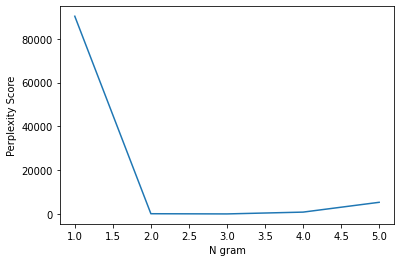

In [ ]:
# Smooth Good Turing
ng = [1,2,3,4,5]
ppl_scores = []
for i in range(1,6):
  model = LanguageModel(i)
  model.train(nested_train_list)
  model.smoothing_good_turing()
  avg_perplexity_score = 0.0
  avg_perplexity_score, ngram_count = model.perplexity(nested_test_list)
  ppl_scores.append(avg_perplexity_score)
plt.plot(ng, ppl_scores)
plt.xlabel("N gram")
plt.ylabel("Perplexity Score")
plt.show()

Training started...
Training started...
Training started...
Training started...
Training started...
[799.5095369240573, 95.21445417031505, 96.54660320926641, 939.1735916713009, 4998.520066943883]


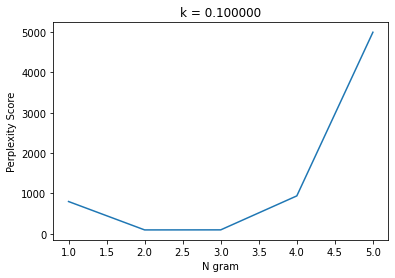

Training started...
Training started...
Training started...
Training started...
Training started...
[799.5095369240573, 95.18276750480216, 96.67034428553566, 939.5714216127049, 5002.017087995679]


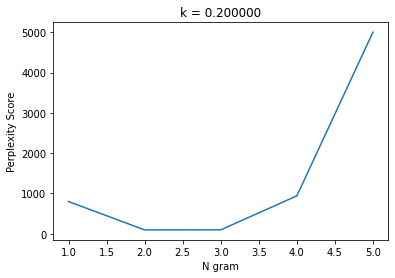

Training started...
Training started...
Training started...
Training started...
Training started...
[799.5095369240573, 95.18090189458428, 96.58771919023621, 941.3353639515043, 5006.919699560801]


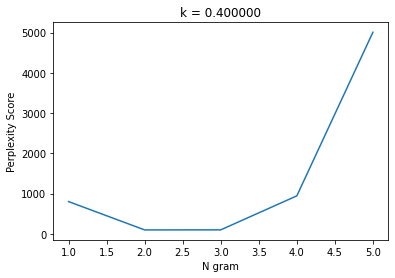

Training started...
Training started...
Training started...
Training started...
Training started...
[799.5095369240573, 95.11913081486108, 96.36256524776877, 940.0143097263095, 4990.673312565771]


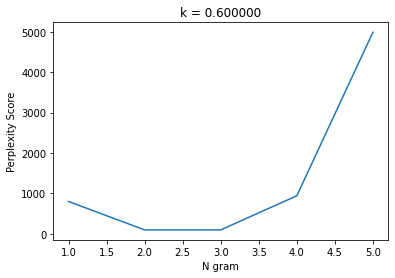

Training started...
Training started...
Training started...
Training started...
Training started...
[799.5095369240573, 95.20216329535486, 96.72801433923811, 939.7308845334893, 4999.899724568795]


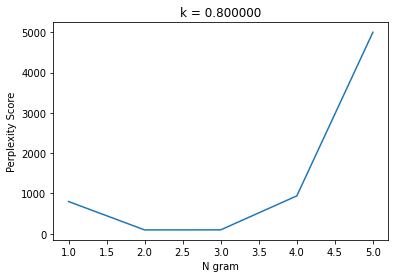

In [ ]:
# Add-k
k_val = [0.1,0.2,0.4,0.6,0.8]
for k in k_val:
  ng = [1,2,3,4,5]
  ppl_scores = []
  for i in range(1,6):
    model = LanguageModel(i)
    model.train(nested_train_list)
    avg_perplexity_score = 0.0
    avg_perplexity_score, ngram_count = model.perplexity(nested_test_list)
    ppl_scores.append(avg_perplexity_score)
  print(ppl_scores)
  plt.plot(ng, ppl_scores)
  plt.xlabel("N gram")
  plt.ylabel("Perplexity Score")
  plt.title('k = %f' %k)
  plt.show()

In [ ]:
backoff_alpha = 1
lr = 1
for _ in range(100):
  model = LanguageModel(3, backoff_alpha)
  model.backoff_context(nested_train_list)
  avg_perplexity_score = 0.0

  avg_perplexity_score, ngram_count = model.perplexity(nested_test_list)
  print(model.backoff_feedback)
  backoff_alpha = backoff_alpha + lr*(1/ngram_count) * model.backoff_feedback

  print(avg_perplexity_score, backoff_alpha)

In [ ]:
backoff_alpha

1.5532421629279198

[799.5095369240573, 90.03571469775375, 24.574652323376664, 19.399709292163738, 20.137741741832937, 20.113875995122854, 19.59412118614167, 18.979996369721675, 18.385729775408493]


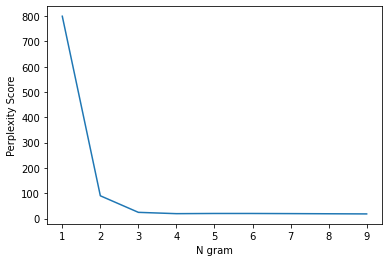

In [ ]:
# Backoff
ng = [1,2,3,4,5,6,7,8,9]
ppl_scores = []
for i in range(1,10):
  model = LanguageModel(i, backoff_alpha = 0.4)
  model.backoff_context(nested_train_list)
  avg_perplexity_score = 0.0
  avg_perplexity_score, ngram_count = model.perplexity(nested_test_list)
  ppl_scores.append(avg_perplexity_score)
print(ppl_scores)
plt.plot(ng, ppl_scores)
plt.xlabel("N gram")
plt.ylabel("Perplexity Score")
plt.show()

[799.5095369240573, 135.08773582137883, 40.74263705823612, 29.210160184568522, 29.361534783118625]


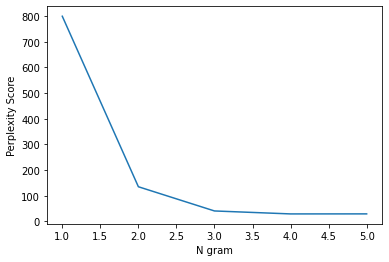

In [ ]:
# Interpolation
ng = [1,2,3,4,5]
ppl_scores = []
for i in range(1,6):
  model = LanguageModel(i)
  model.backoff_context(nested_train_list)
  avg_perplexity_score = 0.0
  avg_perplexity_score, ngram_count = model.perplexity(nested_test_list)
  ppl_scores.append(avg_perplexity_score)
print(ppl_scores)
plt.plot(ng, ppl_scores)
plt.xlabel("N gram")
plt.ylabel("Perplexity Score")
plt.show()

In [ ]:
# Kneser Nay
ng = [1,2,3,4,5]
ppl_scores = []
for i in range(1,6):
  model = LanguageModel(i)
  model.train(nested_train_list)
  avg_perplexity_score = 0.0
  avg_perplexity_score, ngram_count = model.perplexity(nested_test_list)
  ppl_scores.append(avg_perplexity_score)
print(ppl_scores)
plt.plot(ng, ppl_scores)
plt.xlabel("N gram")
plt.ylabel("Perplexity Score")
plt.show()